In [41]:

#important links
## https://github.com/riiid/ednet

In [42]:
import optuna
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import train_test_split
import operator
import random

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('fivethirtyeight')

import riiideducation
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score


In [43]:
# train_df= pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
#                 usecols=[1, 2, 3,4,7,8,9],nrows=10**6, dtype={'timestamp': 'int64', 'user_id': 'int32' ,
#                                                   'content_id': 'int16','content_type_id': 'int8',
#                                                   'answered_correctly':'int8',
#                                                   'prior_question_elapsed_time': 'float32',
#                                                   'prior_question_had_explanation': 'boolean'}
#               )
train_df= pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                nrows=10**6, dtype={'timestamp': 'int64', 'user_id': 'int32' ,
                                                  'content_id': 'int16','content_type_id': 'int8',
                                    'task_container_id':'int16','user_answer':'int8',
                                                  'answered_correctly':'int8',
                                                  'prior_question_elapsed_time': 'float32',
                                                  'prior_question_had_explanation': 'boolean'}
              )

In [22]:
train_df.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [23]:
data = train_df

In [24]:
temp = data[data.user_id == np.random.choice(data.user_id.unique())].sort_values("timestamp")
print (temp.shape)
temp.head(10)

(70, 10)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62689,62689,0,1384495,7900,0,0,0,1,NaN,<NA>
62690,62690,27567,1384495,7876,0,1,1,0,19000.0,False
62691,62691,68558,1384495,175,0,2,2,1,25000.0,False
62692,62692,88741,1384495,1278,0,3,0,0,39000.0,False
62693,62693,157678,1384495,2065,0,4,2,1,18000.0,False
62694,62694,157678,1384495,2064,0,4,1,1,18000.0,False
62695,62695,157678,1384495,2063,0,4,1,0,18000.0,False
62696,62696,211408,1384495,3363,0,5,2,0,22000.0,False
62697,62697,211408,1384495,3364,0,5,2,0,22000.0,False
62698,62698,211408,1384495,3365,0,5,1,0,22000.0,False


# # EDA

1. Time stamp - basically how much time passed from the first question complete and next question started.
         how much time he took, how many question he attempt in a day , like that

In [25]:
data['timestamp'].describe()

count    1.000000e+06
mean     7.344311e+09
std      1.058693e+10
min      0.000000e+00
25%      5.211669e+08
50%      2.824811e+09
75%      1.010186e+10
max      7.809200e+10
Name: timestamp, dtype: float64

In [26]:
# checking null
data['timestamp'].isnull().sum()

0

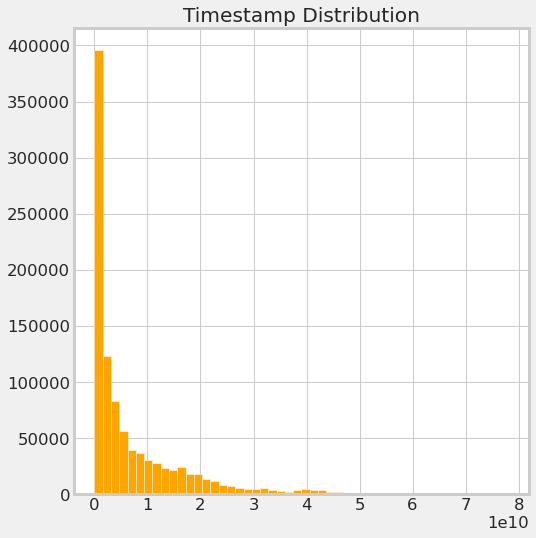

In [27]:
f = plt.figure(figsize=(16, 8))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    data['timestamp'].hist(bins = 50,color='orange')
    plt.title("Timestamp Distribution")


a lot of user a taking a lot of time or gap between, let order by timestamp and replace it by subtracting from previous timestamp 

In [28]:
data = data.sort_values(['user_id','timestamp'])
data.head(20)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [29]:
data = data.sort_values(['user_id','task_container_id'])
data.head(20)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
2,2,118363,115,128,0,0,0,1,55000.0,False
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [30]:
def countplot(column):
    plt.figure(dpi=100)
    sns.countplot(train_data[column])
    plt.show()

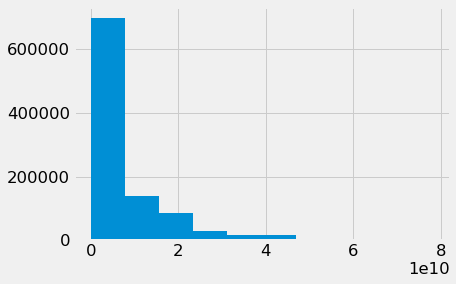

In [31]:
# sns.distplot(data['timestamp'],color='yellow')
# plt.show()
data['timestamp'].hist()
plt.show()

In [32]:
# task contaioner id not in increasing order 
data['task_container_id'] = (
    data
    .groupby('user_id')['task_container_id']
    .transform(lambda x: pd.factorize(x)[0])
    .astype('int16')
)

In [33]:
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
2,2,118363,115,128,0,0,0,1,55000.0,False
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [34]:
data['time_elapsed'] = data.groupby('user_id')['timestamp'].apply(lambda x: x- x.shift(1))

In [35]:
data['time_elapsed'] = data['time_elapsed'].fillna(data.groupby('user_id')['time_elapsed'].transform('mean'))

In [36]:
data.head(5)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,time_elapsed
2,2,118363,115,128,0,0,0,1,55000.0,False,1.484382e+07
0,0,0,115,5692,0,1,3,1,NaN,<NA>,-1.183630e+05
1,1,56943,115,5716,0,2,2,1,37000.0,False,5.694300e+04
3,3,131167,115,7860,0,3,0,1,19000.0,False,7.422400e+04
4,4,137965,115,7922,0,4,1,1,11000.0,False,6.798000e+03


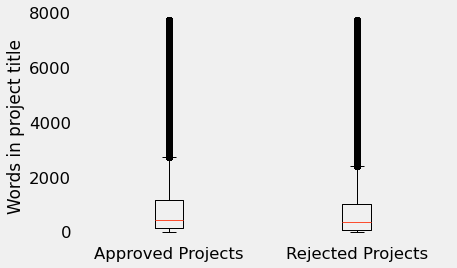

In [38]:
time_correct = data[data['answered_correctly']==1]['task_container_id']
time_wrong = data[data['answered_correctly']!=1]['task_container_id']
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([time_correct, time_wrong])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()


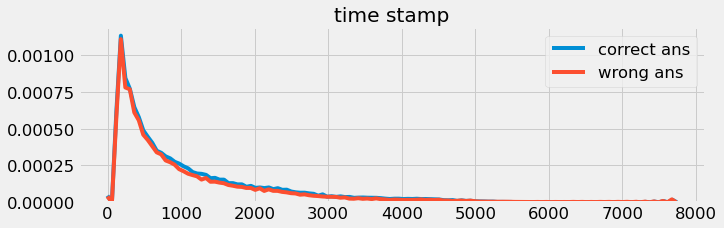

In [39]:
plt.figure(figsize=(10,3))
sns.kdeplot(time_correct ,label="correct ans", bw=0.6)
sns.kdeplot(time_wrong,label="wrong ans", bw=0.6)
plt.title('time stamp')
plt.xlabel('')
plt.legend()
plt.show()


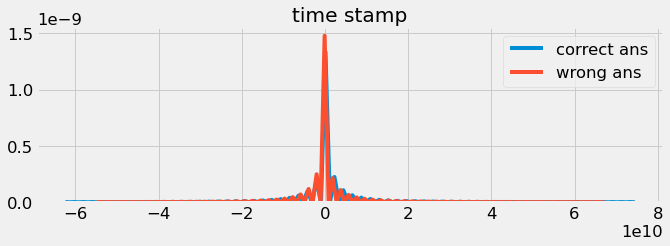

In [40]:
time_correct = data[data['answered_correctly']==1]['time_elapsed']
time_wrong = data[data['answered_correctly']!=1]['time_elapsed']
plt.figure(figsize=(10,3))
sns.kdeplot(time_correct ,label="correct ans", bw=0.6)
sns.kdeplot(time_wrong,label="wrong ans", bw=0.6)
plt.title('time stamp')
plt.xlabel('')
plt.legend()
plt.show()

In [ ]:
def plot_by_dv(data,col):
    time_correct = data[data['answered_correctly']==1][col]
    time_wrong = data[data['answered_correctly']!=1][col]
    plt.figure(figsize=(10,3))
    sns.kdeplot(time_correct ,label="correct ans", bw=0.6)
    sns.kdeplot(time_wrong,label="wrong ans", bw=0.6)
    plt.title('time stamp')
    plt.xlabel('')
    plt.legend()
    plt.show()

# User ID

In [ ]:
# unique user id 
print("total data",len(data),len(data['user_id'].unique()))

In [ ]:
data['total_question_attemp'] = data.groupby('user_id')['user_id'].transform('count')
data['total_question_attemp_correct'] = data.groupby('user_id')['answered_correctly'].transform('sum')
data['total_question_attemp_correct'] = data['total_question_attemp_correct']/data['total_question_attemp']
data.head()

In [ ]:
plot_by_dv(data,'total_question_attemp')

In [ ]:
plot_by_dv(data,'total_question_attemp_correct')

# content_id

In [ ]:
# unique question  
print("total data",len(data),len(data['content_id'].unique()))

In [ ]:
data['question_attemp'] = data.groupby('content_id')['content_id'].transform('count')
data['question_ans_correct'] = data.groupby('content_id')['answered_correctly'].transform('sum')
data['question_ans_correct'] = data['question_ans_correct']/data['question_attemp']
data.head(10)

In [ ]:
plot_by_dv(data,'question_attemp')

In [ ]:
plot_by_dv(data,'question_ans_correct')

# content_type_id

In [ ]:
def stack_plot(data, xtick, col2, col3='total'):
     ind = np.arange(data.shape[0])

     plt.figure(figsize=(20,5))
     p1 = plt.bar(ind, data[col3].values)
     p2 = plt.bar(ind, data[col2].values)
     plt.ylabel('Projects')
     plt.title('Number of projects aproved vs rejected')
     plt.xticks(ind, list(data[xtick].values))
     plt.legend((p1[0], p2[0]), ('total', 'accepted'))
     plt.show()


def univariate_barplots(data, col1, col2, top=False):
	temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
	# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
	temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
	temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

	temp.sort_values(by=['total'],inplace=True, ascending=False)

	if top:
		temp = temp[0:top]

	stack_plot(temp, xtick=col1, col2=col2, col3='total')
	print(temp.head(5))
	print("="*50)
	#print(temp.tail(5))

In [ ]:
data.groupby(['content_type_id','answered_correctly']).agg('count').iloc[:,:1]

In [ ]:
data[data['content_type_id']==1].head()

In [ ]:
## removing latures data
data = data[data['content_type_id']!=1]

# task_container_id

In [ ]:
data.head(10)

In [ ]:
data['task_container_id'].value_counts()

# user_answer

In [ ]:
data['user_answer'].value_counts()

# answered_correctly

In [ ]:
data['answered_correctly'].value_counts()

# prior_question_elapsed_time

In [ ]:
data['prior_question_elapsed_time'].isna().sum()

In [ ]:
data['prior_question_elapsed_time'] = data['prior_question_elapsed_time'].fillna(data.groupby('user_id')['prior_question_elapsed_time'].transform('mean'))

In [ ]:
data.head()

In [ ]:
plot_by_dv(data,'prior_question_elapsed_time')

# prior_question_had_explanation

In [ ]:
data['prior_question_had_explanation'].value_counts()

In [ ]:
data['prior_question_had_explanation'].isnaprior_question_had_explanation().sum()

In [ ]:
data['prior_question_had_explanation'] = \
data['prior_question_had_explanation'].fillna(data['prior_question_had_explanation'].mode()[0])

In [ ]:
data.head()

# Feature engineering

In [ ]:
train = train[train.content_type_id == False]
#arrange by timestamp
train = train.sort_values(['timestamp'], ascending=True)

train.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
results_u.columns = ["answered_correctly_user", 'sum']

In [ ]:
X = train.iloc[:,:]
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c, on=['content_id'], how="left")
X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)

In [ ]:
X.head()

In [ ]:
# fill_mode = lambda col: col.fillna(col.mode())
# X = X.apply(fill_mode, axis=1)

In [ ]:
X.head()

In [ ]:
X["prior_question_had_explanation"].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
X['prior_question_had_explanation'].fillna(X['prior_question_had_explanation'].mode()[0], inplace=True)
X['prior_question_elapsed_time'].fillna(X['prior_question_elapsed_time'].mean(), inplace=True)

X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
X.head()

X = X[['answered_correctly_user', 'answered_correctly_content', 'sum','prior_question_elapsed_time','prior_question_had_explanation_enc']] 
#X.fillna(0.5,  inplace=True)

Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size = 0.2, shuffle=False, random_state=42)

In [ ]:
print("XGBoost version:", xgb.__version__)

In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

x_cfl=XGBClassifier(objective='binary:logistic',eval_metric= 'auc',tree_method = 'gpu_hist',
                    n_jobs=-1)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000,3000,4000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,cv=3)
random_cfl.fit(Xt, Yt)

In [ ]:
val_pred = x_cfl.predict(Xv)
    
# CV score
score = roc_auc_score(Yv, val_pred)
print(f"AUC = {score}")